In [27]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [62]:
column_name = ['player_name','score','player_x',
               'player_y','enemy_count','coin_count',
               'bullet_count','miss_bullet_count','timestamp']
DIR_GAME_DATA = r'C:/Users/Supalerk/Desktop/game_analytics/game-analytics/game_client/game_data.csv'
df = pd.read_csv(  DIR_GAME_DATA
                 , names=column_name
                 , index_col = False
                 )
df.head()

,player_name,score,player_x,player_y,enemy_count,coin_count,bullet_count,miss_bullet_count,timestamp
0,PLAYER,12,447.421286,305.396896,7,5,8,1,1624194794
1,PLAYER,7,404.902825,432.454195,5,2,7,2,1624194825
2,PLAYER,7,404.902825,432.454195,5,2,7,2,1624194825
3,PLAYER,2,368.542959,239.788783,1,1,2,1,1624195135
4,PLAYER,4,417.820000,253.350000,2,2,3,1,1624195147


# Normalization - MinMaxScaler

In [63]:
DIR_TRANSFORM_MODEL = './scaler_model.pkl'
DIR_PREDICTION_MODEL = './kmeans_model.pkl'

col = ['enemy_count', 'score', 'coin_count']
train_df = df[col]

In [64]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(train_df)
train_tf = pd.DataFrame(mm_scaler.transform(train_df), index=df.index, columns=col)

# save scaler model
pickle.dump(mm_scaler, open(DIR_TRANSFORM_MODEL,'wb'))

In [65]:
kmeans = KMeans(n_clusters = 4, random_state=0)
kmeans.fit(train_tf[col])

# save kmeans model
pickle.dump(kmeans, open(DIR_PREDICTION_MODEL,'wb'))

# predict cluster (player style)
df['cluster'] = kmeans.predict(train_tf[col])
df.head()

,player_name,score,player_x,player_y,enemy_count,coin_count,bullet_count,miss_bullet_count,timestamp,cluster
0,PLAYER,12,447.421286,305.396896,7,5,8,1,1624194794,2
1,PLAYER,7,404.902825,432.454195,5,2,7,2,1624194825,2
2,PLAYER,7,404.902825,432.454195,5,2,7,2,1624194825,2
3,PLAYER,2,368.542959,239.788783,1,1,2,1,1624195135,2
4,PLAYER,4,417.820000,253.350000,2,2,3,1,1624195147,2


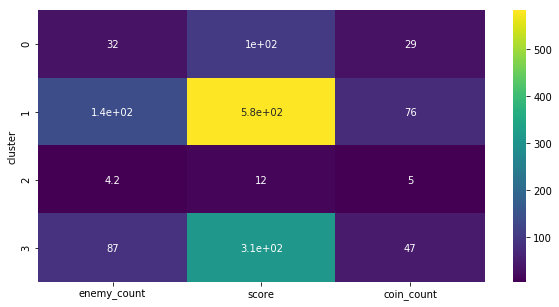

In [66]:
plt.figure(figsize=(10,5))
sns.heatmap(df.groupby('cluster')[col].mean(), cmap='viridis', annot=True )

# TREE-Dendrogram

In [67]:
X = df[col]
y = df['cluster']

[Text(225.533,291.515,'score <= 55.0\nentropy = 1.936\nsamples = 37\nvalue = [9, 7, 14, 7]'),
 Text(112.767,208.225,'entropy = 0.0\nsamples = 14\nvalue = [0, 0, 14, 0]'),
 Text(338.3,208.225,'score <= 200.0\nentropy = 1.574\nsamples = 23\nvalue = [9, 7, 0, 7]'),
 Text(225.533,124.935,'entropy = 0.0\nsamples = 9\nvalue = [9, 0, 0, 0]'),
 Text(451.067,124.935,'enemy_count <= 112.5\nentropy = 1.0\nsamples = 14\nvalue = [0, 7, 0, 7]'),
 Text(338.3,41.645,'entropy = 0.0\nsamples = 7\nvalue = [0, 0, 0, 7]'),
 Text(563.833,41.645,'entropy = 0.0\nsamples = 7\nvalue = [0, 7, 0, 0]')]

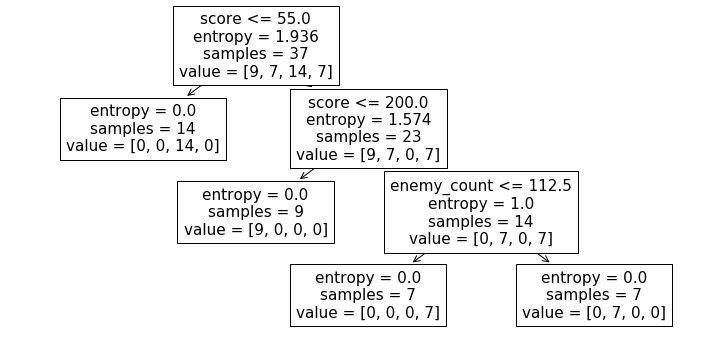

In [68]:
plt.figure(figsize=(12,6))
dtree = DecisionTreeClassifier(criterion = 'entropy', max_depth=3)
dtree.fit(X, y)
tree.plot_tree(
            dtree,
            feature_names = col)

In [69]:
seg_dict = {0:'Casual killer'
           ,1:'Hardcore killer'
           ,2:'Casual achiever'
           ,3:'Hardcore achiever'
           }

In [72]:
test = df.loc[0,col].values.tolist()
test

[7, 12, 5]

In [73]:
scaler_model = pickle.load(open(DIR_TRANSFORM_MODEL,'rb'))
kmeans_model = pickle.load(open(DIR_PREDICTION_MODEL, 'rb'))
scaler_score = scaler_model.transform(np.array(test).reshape(1,-1))
player_type = kmeans_model.predict(scaler_score)
seg_dict[player_type[0]]

'Casual achiever'

In [74]:
df.head()

,player_name,score,player_x,player_y,enemy_count,coin_count,bullet_count,miss_bullet_count,timestamp,cluster
0,PLAYER,12,447.421286,305.396896,7,5,8,1,1624194794,2
1,PLAYER,7,404.902825,432.454195,5,2,7,2,1624194825,2
2,PLAYER,7,404.902825,432.454195,5,2,7,2,1624194825,2
3,PLAYER,2,368.542959,239.788783,1,1,2,1,1624195135,2
4,PLAYER,4,417.820000,253.350000,2,2,3,1,1624195147,2


In [75]:
y_unique_lst = sorted(y.unique().tolist())
i = 0
fig, ax = plt.subplots(len(y_unique_lst), 1, figsize=(20,60), dpi = 300)
for cluster in y_unique_lst:
    new_y = y == cluster
    dtree = DecisionTreeClassifier(criterion = 'entropy', max_depth=4)
    dtree.fit(X, new_y)
    tree.plot_tree(
            dtree,
            feature_names = col,
            # class_names = (new_y * cluster).astype(str),
            filled = True,
            ax = ax[i]
  );
    ax[i].set_title(f'--------------------- CLUSTER NUMBER : {cluster} --------------------- ')
    i+=1
fig.savefig('./dendrogram_one_vs_rest.png')

# Visualization

In [89]:
df['cluster_name'] = df['cluster'].map(seg_dict)

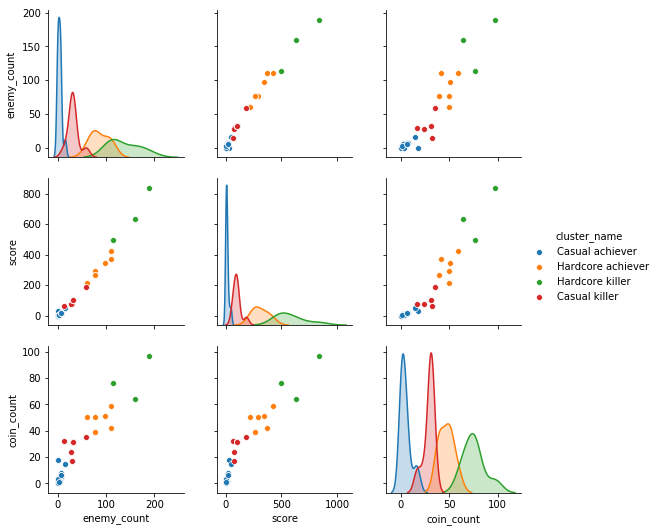

In [90]:
col_plot = col+['cluster_name']
sns.pairplot(df[col_plot], vars=df[col_plot].columns[:-1],hue='cluster_name')